In [9]:
class Config:
  DATASET_PATH =r"C:\Users\csume\AnomalyDetection\mv_eski\Train"
  SINGLE_TEST_PATH = r"C:\Users\csume\AnomalyDetection\mv_eski\Test\test004"
  BATCH_SIZE = 4
  EPOCHS = 1
  MODEL_PATH = r"C:\Users\csume\AnomalyDetection\calisma1.hdf5"

In [30]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    """if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})"""
    training_set = get_training_set()
    training_set = np.array(training_set) #shape'i (73, 256, 256) formatına getirilir.
    training_set = training_set.reshape(1, training_set.shape[0], training_set.shape[1], training_set.shape[2], 1)
    
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(64, (5, 5), padding="same"), input_shape=(None,256, 256, 1)))
    seq.add(LayerNormalization())
    
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (5, 5), activation="sigmoid", padding="same")))
    print(seq.summary())
    
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6)) 
    seq.fit(training_set, training_set,
            epochs=Config.EPOCHS, shuffle=False)
    
    
    
    #seq.save(Config.MODEL_PATH)
    return seq

In [31]:
import os
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "png":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    #all_frames.append(img)
                    clips.append(img)
            
    
    return clips

In [32]:
def get_single_test():
    sz = 17
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "png":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    #return test
    return test

In [33]:
import matplotlib.pyplot as plt

def evaluate():
    
    model = get_model(True)
    print("got model")
    test = get_single_test()
    print("got test")
    sz = test.shape[0] - 1
    sequences = np.zeros((sz,1, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((1,256, 256, 1))
        for j in range(0, 1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, None, 256, 256, 64 1664      
_________________________________________________________________
layer_normalization_21 (Laye (None, None, 256, 256, 64 128       
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, None, 256, 256, 32 110720    
_________________________________________________________________
layer_normalization_22 (Laye (None, None, 256, 256, 32 64        
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, None, 256, 256, 16 27712     
_________________________________________________________________
layer_normalization_23 (Laye (None, None, 256, 256, 16 32        
_________________________________________________________________
conv_lst_m2d_15 (ConvLSTM2D) (None, None, 256, 256, 32

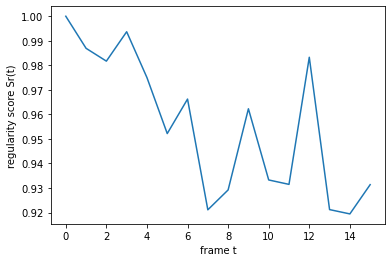

In [34]:
evaluate()